<a href="https://colab.research.google.com/github/hyunwookim129/stock_predict/blob/main/LSTM_Stock_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

국방 AI 경진대회를 준비하기 위해 엘리스에서 인공지능 공부를 시작하였습니다. 공부를 진행하는 와중 주가 예측하는 예시가 있었고, 경제와 주식에 관심이 있던 저는 이 예시를 단순 따라 하기보다는 나만의 방식과 모델을 만들고 싶은 욕구가 생겼습니다. 학습 내용은 하루 뒤 주가 예측이었고 사용하는 데이터도 주가 하나만을 사용했습니다.

제가 여기서 발전 시킨 방식은 single layer LSTM 모델을 사용해 5일 (5 trading days) 뒤 주가 예측. 단순히 주가만 가지고 예측이 아닌 다른 경제 데이터도 불러오고 사용해서 학습하는 방식입니다. 이 모델에서는 VIX data(뉴욕 주식시장 변동성지수)를 주가와 함께 사용하였습니다. 이 방식을 다른 데이터를 불러와 적용한다면 더 복잡한 데이터 조합을 인공지능 학습에 사용해 주가 예측에 사용할 수 있을 것입니다. 이 모델은 여러 논문에 근거해 상관관계가 높은 데이터 삭제, single layer LSTM을 사용, 데이터 정제 방식도 엘리스 예시와 조금씩 다르게 진행했습니다.

코드는 google colab 에서 실행되었고 데이터 읽기, 정제, 시각화 순으로 되어있습니다.

In [ ]:
pip install --upgrade tensorflow


In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from datetime import datetime

import pandas as pd
import os

# 폴더 생성
folder_path = '/content/Stocks'
os.makedirs(folder_path, exist_ok=True)

# 하이닉스 주가 와 vix 데이터 불러오기 날짜: '2019-03-01' 에서 오늘
SK_Hynix = yf.download('000660.KS', start='2019-03-01', end=datetime.today().strftime('%Y-%m-%d'))
vix_data = yf.download('^VIX', start='2019-03-01',  end=datetime.today().strftime('%Y-%m-%d'))

# CSV 형태로 저장
SK_Hynix.to_csv('Stocks/SK하이닉스.csv')
vix_data.to_csv('Stocks/vix_data.csv')

#데이터 정제

# 상관관계가 높은 데이터 제거
columns_to_drop = ['Open', 'Low', 'High', 'Adj Close']
data_df = pd.read_csv('./Stocks/SK하이닉스.csv', index_col="Date")
data_df = data_df.drop(columns=columns_to_drop)

vix_data = pd.read_csv('./Stocks/vix_data.csv', index_col="Date")
columns_to_drop = ['Volume','Open', 'Low', 'High', 'Adj Close']

# 겹치는 헤더가 있어 해더 이름 바꾸기
vix_data = vix_data.drop(columns=columns_to_drop)
vix_data = vix_data.rename(columns={'Close': 'VIXclose'})

# 두 데이터 합체
merged_data = data_df.merge(vix_data, left_index=True, right_index=True, how='left')

# drop na. 미국 데이터랑 한국 데이터라 마켓이 오픈되있는 날이 다름. 겹치지 않은 적은 데이터 드랍
merged_data.to_csv('./Stocks/SK하이닉스_with_VIX.csv')
merged_data = merged_data.dropna()

# 5일뒤 가격을 타겟으로 놓기 위해 close 데이터 5일씩 앞으로
merged_data['Target'] = merged_data['Close'].shift(-5)

#혹시 모를 na 다시 드랍
merged_data = merged_data.dropna()

# MinMaxScaler 를 통해 정규화
scaler = MinMaxScaler()
merged_data[['Close', 'Volume', 'VIXclose']] = scaler.fit_transform(merged_data[['Close', 'Volume', 'VIXclose']])

# 후에 Target 만 reverse 해야하기 때문에 다른 이름으로 타겟 정규화
scaler1 = MinMaxScaler()
merged_data['Target'] = scaler1.fit_transform(merged_data['Target'].values.reshape(-1,1))

# 정제된 데이터 확인
print(merged_data)

# 테스트 트레이닝 데이터 분리
train_size = int(len(merged_data) * 0.80)  # 데이터의 80% 를 사용해 학습
train_data = merged_data.values[:train_size]
test_data = merged_data.values[train_size:]

# LSTM sequence 만들기
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)
seq_length = 10  # 최근 10일 데이터 사용
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)







[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
               Close    Volume  VIXclose    Target
Date                                              
2019-03-04  0.081967  0.257521  0.043429  0.040984
2019-03-05  0.077283  0.180961  0.044975  0.053864
2019-03-06  0.058548  0.258910  0.059030  0.043326
2019-03-07  0.058548  0.177674  0.070977  0.049180
2019-03-08  0.042155  0.186510  0.063387  0.058548
...              ...       ...       ...       ...
2023-11-13  0.804450  0.138103  0.045257  0.799766
2023-11-14  0.783372  0.135222  0.036824  0.806792
2023-11-15  0.831382  0.188834  0.037105  0.798595
2023-11-16  0.810304  0.128265  0.039072  0.759953
2023-11-17  0.782201  0.127332  0.031764  0.791569

[1128 rows x 4 columns]


In [ ]:
# single layer LSTM 모델
model = Sequential()
model.add(LSTM(25, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss=MeanSquaredError())

# 학습
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# 평가
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")

Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
28/28 [==============================] - 3s 9ms/step - loss: 0.1588
Epoch 2/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 3/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 4/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 5/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 6/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 7/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 8/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 9/50
28/28 [==================

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Test Loss: 0.0037824735045433044


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - 2s 9ms/step


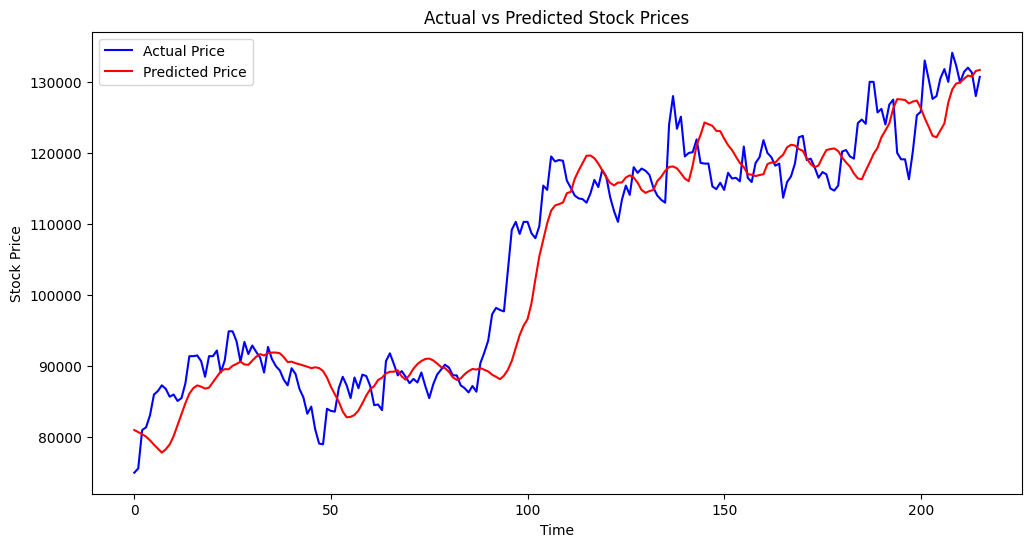

In [ ]:
# 결과 시각화
import matplotlib.pyplot as plt

# Inverse scaling 사용해 실제 가격 반영
predicted_prices_scaled = model.predict(X_test)
predicted_actual = scaler1.inverse_transform(np.array(predicted_prices_scaled).reshape(-1,1))
actual_price = scaler1.inverse_transform(np.array(y_test).reshape(-1,1))

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(actual_price, label='Actual Price', color='blue')
plt.plot(predicted_actual, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# 모델 summary
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 25)                2900      
                                                                 
 dense_16 (Dense)            (None, 1)                 26        
                                                                 
Total params: 2926 (11.43 KB)
Trainable params: 2926 (11.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


결과는 근접하게 나왔으나 lagging 하는 모습을 보였습니다. 더 좋은 예측을 위해 다른 외부 데이터(미국 증시: sp 500 나 물가, 금리 데이터 등)을 사용해 모델을 발전시킬 수 있다고 생각합니다.

이 프로젝트는 단순 코드를 갔다 쓰는 게 아닌, 관련 논문도 찾아보고 적용하는 방식으로 이론과 코딩 공부를 더 하게 되어 전반적인 지식과 코딩 실력도 늘게 되었습니다.